# Text classification with BERT in PyTorch

One of the most popular language models is [BERT](https://arxiv.org/abs/1810.04805), developed by researchers at Google. BERT stands for Bidirectional Encoder Representations from Transformers. It uses the Transformer architecture to pretrain bidirectional "language models". By adding just one task-specific output layer, it is possible to use such a pre-trained BERT model on a variety of NLP tasks. In this notebook, we're going to investigate its performance on a text classification task, where the task is to predict whether the text is difficult to read or not. 

## Data

The data is provided by the guideline of milestone 2 in course SIADS696. It can be found in the following:
https://www.kaggle.com/t/5a1872e494574cc7bbf433fa8f4687d9

In [1]:
import warnings
# Disable 3 types of warning
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=(FutureWarning))
warnings.filterwarnings("ignore",category=(RuntimeWarning))

First, we split up the data into a train, development and test portion. 

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# load train data
train_data_path="./01_data/WikiLarge_Train.csv"
train_data=pd.read_csv(train_data_path)

In [3]:
# look for the records with different labels 
def duple_labels(data):
    df_by=pd.DataFrame(data.groupby(['original_text','label']).count().reset_index()[["original_text","label"]])
    df_by=df_by.groupby(by='original_text').count().sort_values('label',ascending=False).reset_index()
    diff_labels=df_by[df_by['label']>1]
    diff_labels.columns=['original_text','duple']
    print("Records with different labels: %.2f%%" %(100*len(diff_labels)/len(data)))
    return diff_labels

In [4]:
# remove the records with different labels
duple_data=duple_labels(train_data)
train_data=train_data.merge(duple_data,how='left',on="original_text")
train_data=train_data[train_data['duple'].isnull()].drop(axis=1,columns=['duple'])

Records with different labels: 0.46%


In [5]:
train_data

,original_text,label
0,There is manuscript evidence that Austen conti...,1
1,"In a remarkable comparative analysis , Mandaea...",1
2,"Before Persephone was released to Hermes , who...",1
3,Cogeneration plants are commonly found in dist...,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1
...,...,...
416763,A Duke Nukem 3D version has been sold for Xbox...,0
416764,"However , it is becoming replaced as a method ...",0
416765,There are hand gestures in both Hindu and Budd...,0
416766,"If it is necessary to use colors , try to choo...",0


In [6]:
train_data

,original_text,label
0,There is manuscript evidence that Austen conti...,1
1,"In a remarkable comparative analysis , Mandaea...",1
2,"Before Persephone was released to Hermes , who...",1
3,Cogeneration plants are commonly found in dist...,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1
...,...,...
416763,A Duke Nukem 3D version has been sold for Xbox...,0
416764,"However , it is becoming replaced as a method ...",0
416765,There are hand gestures in both Hindu and Budd...,0
416766,"If it is necessary to use colors , try to choo...",0


The above records with different labels should be dropped since we don't know which one is correct. However,the duplicated record with same label can be kept with only one since it has one label, the purpose of dropping those is to:
- Reduce the training duration.
- Reduce the chances to increasing the importances of those duplicated records.

In [7]:
# keep the first one for those duplicated records
#original_len=len(train_data)
#train_data=train_data.drop_duplicates(subset=['original_text'])
#print("Records in duplication : %.2f%%" %(100*(original_len-len(train_data))/original_len))

Records in duplication : 0.00%


In [8]:
train_data

,original_text,label
0,There is manuscript evidence that Austen conti...,1
1,"In a remarkable comparative analysis , Mandaea...",1
2,"Before Persephone was released to Hermes , who...",1
3,Cogeneration plants are commonly found in dist...,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1
...,...,...
416763,A Duke Nukem 3D version has been sold for Xbox...,0
416764,"However , it is becoming replaced as a method ...",0
416765,There are hand gestures in both Hindu and Budd...,0
416766,"If it is necessary to use colors , try to choo...",0


### Produce data set

In [9]:
size=round(len(train_data)*1)
r_train=train_data.sample(n=size,random_state=1)
texts=list(r_train["original_text"])
labels=list(r_train["label"])
    
rest_texts, test_texts, rest_labels, test_labels = train_test_split(texts, labels, test_size=0.1, random_state=1)
train_texts, dev_texts, train_labels, dev_labels = train_test_split(rest_texts, rest_labels, test_size=0.1, random_state=1)

print("Train size:", len(train_texts))
print("Dev size:", len(dev_texts))
print("Test size:", len(test_texts))

Train size: 332783
Dev size: 36976
Test size: 41085


Text(0.5, 1.0, 'Distribution of original text length in words')

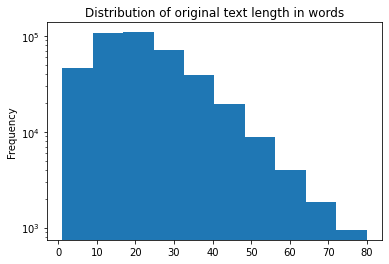

In [10]:
import matplotlib.pyplot as plt
# TRAIN SET 
train_data['original_text'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of original text length in words')

In [11]:
print("maximum numbers of words is:",train_data['original_text'].apply(lambda x: len(x.split())).max())

maximum numbers of words is: 80


In [12]:
train_data['original_text'].apply(lambda x: len(x.split())).describe()

count    410844.000000
mean         21.971739
std          12.685777
min           1.000000
25%          13.000000
50%          20.000000
75%          29.000000
max          80.000000
Name: original_text, dtype: float64

Next, we need to determine the number of labels in our data. We'll map each of these labels to an index. In our dataset, there are 2 labels: 1 (text needs to be simplified), 0 (the text is NOT needed to be simplified).

In [13]:
target_names = list(set(labels))
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(label2idx)

{0: 0, 1: 1}


## Text Preprocessing

## Baseline

Let's train a baseline model for our task. In this way we have something to compare BERT's performance to. As our baseline, we choose a simple Logistic Regression classifier from Scikit-learn. We use grid search to find the optimal settings for its hyperparameter _C_. At the end of this process, we find that our best baseline classifier obtains an accuracy of 62.67%.

In [14]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(multi_class="ovr", solver="lbfgs",max_iter=20))
])

parameters = {'lr__C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]}

best_classifier = GridSearchCV(pipeline, parameters, cv=5, verbose=6)
best_classifier.fit(train_texts, train_labels)
best_predictions = best_classifier.predict(test_texts)

baseline_accuracy = np.mean(best_predictions == test_labels)
print("Baseline accuracy:", baseline_accuracy)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .........................lr__C=0.1;, score=0.672 total time=  10.8s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .........................lr__C=0.1;, score=0.678 total time=  10.7s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .........................lr__C=0.1;, score=0.674 total time=  10.8s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .........................lr__C=0.1;, score=0.674 total time=  10.7s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END .........................lr__C=0.1;, score=0.673 total time=  10.7s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .........................lr__C=0.5;, score=0.678 total time=  11.0s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .........................lr__C=0.5;, score=0.685 total time=  11.1s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .........................lr__C=0.5;, score=0.676 total time=  11.0s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .........................lr__C=0.5;, score=0.681 total time=  11.1s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END .........................lr__C=0.5;, score=0.681 total time=  11.0s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...........................lr__C=1;, score=0.680 total time=  11.0s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...........................lr__C=1;, score=0.681 total time=  11.0s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...........................lr__C=1;, score=0.679 total time=  10.9s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...........................lr__C=1;, score=0.681 total time=  10.9s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...........................lr__C=1;, score=0.681 total time=  10.9s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...........................lr__C=2;, score=0.679 total time=  10.7s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...........................lr__C=2;, score=0.686 total time=  11.1s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...........................lr__C=2;, score=0.679 total time=  10.7s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...........................lr__C=2;, score=0.678 total time=  10.9s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...........................lr__C=2;, score=0.684 total time=  10.7s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...........................lr__C=5;, score=0.677 total time=  10.9s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...........................lr__C=5;, score=0.684 total time=  10.7s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...........................lr__C=5;, score=0.678 total time=  10.8s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...........................lr__C=5;, score=0.682 total time=  11.1s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...........................lr__C=5;, score=0.680 total time=  10.9s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..........................lr__C=10;, score=0.679 total time=  10.9s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..........................lr__C=10;, score=0.683 total time=  10.9s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..........................lr__C=10;, score=0.678 total time=  11.0s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..........................lr__C=10;, score=0.680 total time=  11.2s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ..........................lr__C=10;, score=0.677 total time=  11.0s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .........................lr__C=100;, score=0.680 total time=  10.8s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .........................lr__C=100;, score=0.682 total time=  10.6s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .........................lr__C=100;, score=0.677 total time=  10.6s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .........................lr__C=100;, score=0.680 total time=  11.0s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END .........................lr__C=100;, score=0.676 total time=  10.8s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ........................lr__C=1000;, score=0.680 total time=  11.1s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ........................lr__C=1000;, score=0.681 total time=  10.7s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ........................lr__C=1000;, score=0.677 total time=  10.8s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ........................lr__C=1000;, score=0.680 total time=  11.3s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ........................lr__C=1000;, score=0.676 total time=  10.9s


C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Baseline accuracy: 0.6812218571254716


## BERT

Now we move to BERT. The team at [HuggingFace](https://github.com/huggingface) has developed a great Python library, [transformers](https://github.com/huggingface/transformers), with implementations of an impressive number of transfer-learning models in PyTorch and Tensorflow. It makes finetuning these models pretty easy. Let's first install this library. 

In [15]:
!pip install transformers torch

You really need a GPU to finetune BERT. Still, to make sure this code runs on any machine we'll let PyTorch determine whether a GPU is available.

In [16]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Initializing a model

Google has made available a range of BERT models for us to experiment with. For English, there is a choice between three models: `bert-large-uncased` is the largest model that will likely give the best results. Its smaller siblings are `bert-base-uncased` and `bert-base-cased`, which are more practical to work with. For Chinese there is `bert-base-chinese`, and for the other languages we have `bert-base-multilingual-uncased` and `bert-base-multilingual-cased`. 

Uncased means that the training text has been lowercased and accents have been stripped. This is usually better, unless you know that case information is important for your task, such as with Named Entity Recognition. 

In our example, we're going to investigate sentiment analysis on English. We'll therefore use the English BERT-base model.

In [17]:
#BERT_MODEL = "bert-large-uncased"
BERT_MODEL = "distilbert-base-uncased"

Each model comes with its own tokenizer. This tokenizer splits texts into [word pieces](https://github.com/google/sentencepiece). In addition, we'll tell the tokenizer it should lowercase the text, as we're going to work with the uncased model. 

In [18]:
from transformers import BertTokenizer,DistilBertTokenizer
import transformers
# clean cache for pretrained model
#transformers.utils.move_cache()

#tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL,do_lower_case=True)

A full BERT model consists of a common, pretrained core, and an extension on top that depends on the particular NLP task. After all, the output of a sequence classification model, where we have just one prediction for every sequence, looks very different from the output of a sequence labelling or question answering model. As we're looking at sentiment classification, we're going to use the pretrained BERT model with a final layer for sequence classification on top.

In [19]:
from transformers import BertForSequenceClassification,DistilBertForSequenceClassification

#model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
model = DistilBertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx),
                                                            output_attentions = False,
                                                            output_hidden_states = False,)
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

### Preparing the data

Next we need to prepare our data for BERT. We'll present every document as a BertInputItem object, which contains all the information BERT needs: 

- a list of input ids. Take a look at the logging output to see what this means. Every text has been split up into subword units, which are shared between all the languages in the multilingual model. When a word appears frequently enough in a combined corpus of all languages, it is kept intact. If it is less frequent, it is split up into subword units that do occur frequently enough across all languages. This allows our model to process every text as a sequence of strings from a finite vocabulary of limited size. Note also the first `[CLS]` token. This token is added at the beginning of every document. The vector at the output of this token will be used by the BERT model for its sequence classification tasks: it serves as the input of the final, task-specific part of the neural network.
- the input mask: the input mask tells the model which parts of the input it should look at and which parts it should ignore. In our example, we have made sure that every text has a length of 100 tokens. This means that some texts will be cut off after 100 tokens, while others will have to be padded with extra tokens. In this latter case, these padding tokens will receive a mask value of 0, which means BERT should not take them into account for its classification task. 
- the segment_ids: some NLP task take several sequences as input. This is the case for question answering, natural language inference, etc. In this case, the segment ids tell BERT which sequence every token belongs to. In a text classification task like ours, however, there's only one segment, so all the input tokens receive segment id 0.
- the label id: the id of the label for this document.

In [20]:
import logging
import numpy as np

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

#MAX_SEQ_LENGTH=100
MAX_SEQ_LENGTH=80

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        

def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""
    
    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))

        
    return input_items

train_features = convert_examples_to_inputs(train_texts, train_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
dev_features = convert_examples_to_inputs(dev_texts, dev_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_examples_to_inputs(test_texts, test_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)

Finally, we're going to initialize a data loader for our training, development and testing data. This data loader puts all our data in tensors and will allow us to iterate over them during training.

In [21]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    #dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    # dataloader tuning in https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
   
    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size,num_workers=2,pin_memory=True)
    return dataloader

#BATCH_SIZE = 16
# Tuning in https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification
BATCH_SIZE = 16

train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)

### Evaluation method

Now it's time to write our evaluation method. This method takes as input a model and a data loader with the data we would like to evaluate on. For each batch, it computes the output of the model and the loss. We use this output to compute the obtained precision, recall and F-score. During training, we will print the simple numbers. When we evaluate on the test set, we will output a full classification report.

In [22]:
def evaluate(model, dataloader):
    model.eval()
    
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            #tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
            #                              token_type_ids=segment_ids, labels=label_ids)[:2]
            tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
                                         labels=label_ids)[:2]  # for distilbert
        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()
        
        predicted_labels += list(outputs)
        correct_labels += list(label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)
        
    return eval_loss, correct_labels, predicted_labels

### Training

Now it's time to start training. We're going to use the AdamW optimizer with a base learning rate of 5e-5, and train for a maximum of 100 epochs. Here are some additional things to note: 

- Gradient Accumulation allows us to keep our batches small enough to fit into the memory of our GPU, while getting the advantages of using larger batch sizes. In practice, it means we sum the gradients of several batches, before we perform a step of gradient descent. 
- We use the WarmupLinearScheduler to vary our learning rate during the training process. First, we're going to start with a small learning rate, which increases linearly during the warmup stage. Afterwards it slowly decreases again.

In [23]:
from transformers import AdamW,get_linear_schedule_with_warmup

GRADIENT_ACCUMULATION_STEPS = 1
# Tuning in https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification
#NUM_TRAIN_EPOCHS = 20
NUM_TRAIN_EPOCHS = 3
#LEARNING_RATE = 5e-5
LEARNING_RATE = 1e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = 600 #int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps,num_training_steps=num_train_steps)


We're finally ready to train our model. At each epoch, we're going to train it on our training data and evaluate it on the development data. We keep a history of the loss, and stop training when the loss on the development set doesn't improve for a certain number of steps (we call this number our `patience`). Whenever the development loss of our model improves, we save it. 

##### Add new tokens into existing model for training

In [24]:
def check_vocab(c_list, vocabulary, response='default'):
    try:
        words = set([w for line in c_list for w in line.split()])
        u_list = words.difference(set(vocabulary))
        k_list = words.difference(u_list)
    
        if response=='default':
            print('Unknown words:', len(u_list), '| Known words:', len(k_list))
        elif response=='unknown_list':
            return list(u_list)
        elif response=='known_list':
            return list(k_list)
    except:
        return []

In [25]:
# clean the memory for GPU computation
import torch,gc
gc.collect()
torch.cuda.empty_cache()

In [26]:
import os
from tqdm import trange
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support

OUTPUT_DIR = "./tmp/"
MODEL_FILE_NAME = "pytorch_model.bin"
PATIENCE = 2
 # tuning guide:https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
torch.backends.cudnn.benchmark = True

loss_history = []
no_improvement = 0
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        #outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
        outputs = model(input_ids, attention_mask=input_mask,labels=label_ids)
        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)  
            
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            # optimizer.zero_grad()
            # tuning guide:https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
            #for param in model.parameters():
            #    param.grad = None
            scheduler.step()
            
    dev_loss, _, _ = evaluate(model, dev_dataloader)
    
    print("Loss history:", loss_history)
    print("Dev loss:", dev_loss)
    
    if len(loss_history) == 0 or dev_loss < min(loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1
    
    if no_improvement >= PATIENCE: 
        print("No improvement on development set. Finish training.")
        break
        
    
    loss_history.append(dev_loss)

Epoch:   0%|                                                                                     | 0/3 [00:00<?, ?it/s]

Training iteration:   0%|          | 0/20799 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/2311 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.47161116057379016


Epoch:  33%|███████████████████████▋                                               | 1/3 [1:03:35<2:07:10, 3815.31s/it]

Training iteration:   0%|          | 0/20799 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/2311 [00:00<?, ?it/s]

Loss history: [0.47161116057379016]
Dev loss: 0.4654343869716045


Epoch:  67%|███████████████████████████████████████████████▎                       | 2/3 [2:06:51<1:03:24, 3804.07s/it]

Training iteration:   0%|          | 0/20799 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/2311 [00:00<?, ?it/s]

Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [3:10:23<00:00, 3807.71s/it]

Loss history: [0.47161116057379016, 0.4654343869716045]
Dev loss: 0.4959993074655739


### Evaluation

Let's now evaluate the model on some documents it has never seen. We'll load our best model and have it predict the labels for all documents in our data. We'll compute its precision, recall and F-score for the training, development and test set and print a full classification report for the test set.

In [27]:
model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
#model = BertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = len(target_names))
model=DistilBertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = len(target_names),
                                                            output_attentions = False,
                                                            output_hidden_states = False,)
model.to(device)

model.eval()

_, train_correct, train_predicted = evaluate(model, train_dataloader)
_, dev_correct, dev_predicted = evaluate(model, dev_dataloader)
_, test_correct, test_predicted = evaluate(model, test_dataloader)

print("Training performance:", precision_recall_fscore_support(train_correct, train_predicted, average="micro"))
print("Development performance:", precision_recall_fscore_support(dev_correct, dev_predicted, average="micro"))
print("Test performance:", precision_recall_fscore_support(test_correct, test_predicted, average="micro"))

bert_accuracy = np.mean(test_predicted == test_correct)

print(classification_report(test_correct, test_predicted))

Evaluation iteration:   0%|          | 0/20799 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/2311 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/2568 [00:00<?, ?it/s]

Training performance: (0.8289515990900977, 0.8289515990900977, 0.8289515990900977, None)
Development performance: (0.7711218087408048, 0.7711218087408048, 0.7711218087408048, None)
Test performance: (0.768942436412316, 0.768942436412316, 0.7689424364123161, None)
              precision    recall  f1-score   support

           0       0.78      0.75      0.76     20458
           1       0.76      0.79      0.77     20627

    accuracy                           0.77     41085
   macro avg       0.77      0.77      0.77     41085
weighted avg       0.77      0.77      0.77     41085



We see that BERT obtains an accuracy of around 70% on the test data. This is around 8% more than our initial baseline classifier. This confirms that BERT's transfer learning helps us achieve significantly higher accuracies for small datasets.

<AxesSubplot:>

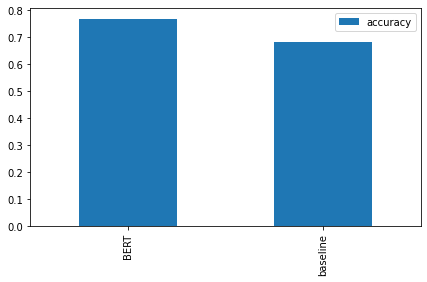

In [28]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({"accuracy": {"baseline": baseline_accuracy, "BERT": bert_accuracy}})
plt.rcParams['figure.figsize'] = (7,4)
df.plot(kind="bar")

##### Export test data without correct classification into csv file for further analysis

In [29]:
import datetime 
error_ind=np.where((test_correct-test_predicted)!=0)
error_list=pd.DataFrame(columns=["original_text","label"])
for i in error_ind[0]:
    error_list=error_list.append({"original_text":test_texts[i],"label":test_correct[i]},ignore_index=True)
error_list.to_csv("./tmp/test_error_"+str(datetime.datetime.now())[:10] + '.csv')
test_data=pd.DataFrame(columns=["original_text","label"])
test_data['original_text']=test_texts
test_data['label']=test_labels
test_data.to_csv("./tmp/test_full_"+str(datetime.datetime.now())[:10] + '.csv')

In [30]:
# Loading the test data for submission
sub_data_path="./01_data/WikiLarge_Test.csv"
sub_data=pd.read_csv(sub_data_path)

sub_texts=list(sub_data["original_text"])
sub_labels=[1 for i in range(len(sub_texts))]

print("Submission Test size:", len(sub_data))

Submission Test size: 119092


In [31]:
# Convert test data of submission to features
sub_features = convert_examples_to_inputs(sub_texts, sub_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
sub_dataloader = get_data_loader(sub_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)

In [32]:
# Predict the result, and discard the evaluatoin result, only take the prediction result.
model.eval()
_, _, sub_predicted = evaluate(model, sub_dataloader)

Evaluation iteration:   0%|          | 0/7444 [00:00<?, ?it/s]

In [33]:
# Produce the submission file
df_sub=pd.DataFrame(columns=["id","label"])
df_sub['label']=sub_predicted
df_sub['id']=[i for i in range(len(sub_predicted))]
df_sub.to_csv("./tmp/submission.csv",index=False)